In [1]:
import glob, os
import pathlib
import json
import yaml

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from pprint import pprint
import re
import dask

from dotty_dict import dotty

%matplotlib inline

In [2]:
# avoid the module's method call deprecation
try:
    collectionsAbc = collections.abc
except AttributeError:
    collectionsAbc = collections

Configuring Juputer's options to present more things to the output.

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [4]:
processing_category = "mfcc"

In [5]:
def shuffle_data(df_ml_data, config):
    """

    :param df_ml_data: (Pandas DataFrame) the data to be shuffled
    :param config: (dict) the configuration data
    :return: (NumPy array) the shuffled data
    """
    df_ml_cols = df_ml_data.columns
    # convert DataFrame to NumPy array
    ml_values = df_ml_data.values
    # shuffle the data
    random.seed(a=config.get("random_seed"))
    random.shuffle(ml_values)
    # convert the NumPy array to DF
    df_ml_shuffle = pd.DataFrame(data=ml_values, columns=df_ml_cols)
    return df_ml_shuffle

# Load Data GroundTruth

## Path declaration

In [6]:
path_config = os.path.join(os.getcwd(), os.pardir, "configuration.yaml")

In [7]:
path_app = os.path.join(os.path.abspath(os.getcwd()), os.pardir)
# path = os.path.join(path, 'danceability', 'features', 'mp3')
print('Current path:', path_app)
print('Type:', type(path_app))

Current path: /home/iotlab_user/Desktop/google2020/gsoc_ml_infrastructure/notebooks/..
Type: <class 'str'>


## Count all the JSON data included in files

In [8]:
counter = 0
for root, dirs, files in os.walk(path_app):
    for file in files:
        if file.endswith(".json"):
#             print(os.path.join(root, file))
            counter += 1
            
print('counted json files:', counter)

counted json files: 10471


## Load the GroundTruth file

In [9]:
with open(os.path.join(path_app, 'acousticbrainz-datasets/danceability/metadata/groundtruth.yaml'), 'r') as stream:
    try:
        groundTr_data = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [10]:
len(groundTr_data['groundTruth'].keys())

225

## Load config

In [11]:
with open(path_config, 'r') as conf_stream:
    try:
        config_data = yaml.safe_load(conf_stream)
    except yaml.YAMLError as exc:
        print(exc)

In [12]:
config_data

{'ground_truth_directory': 'acousticbrainz-datasets',
 'class_dir': 'danceability',
 'enumeration_columns': ['tonal_chords_key',
  'tonal_chords_scale',
  'tonal_key_key',
  'tonal_key_scale'],
 'remove_columns': ['json_directory', 'track'],
 'exports_directory': 'exports',
 'evaluations_directory': 'evaluations',
 'tracks_in_csv_format': 'tracks_csv',
 'delete_logs': True,
 'log_directory': 'logs',
 'logging_level': 0,
 'scaling': 'standard_scaled',
 'excludedDescriptors': ['metadata.tags*'],
 'processing': {'raw': [],
  'basic': {'preprocess': [{'transfo': 'remove',
     'params': {'descriptorNames': ['metadata.*',
       '*dmean*',
       '*dvar*',
       '*.min',
       '*.max',
       '*cov',
       'tonal.thpcp',
       'lowlevel.spectral_energyband_high.*',
       'lowlevel.silence_rate*']}},
    {'transfo': 'enumerate',
     'params': {'descriptorNames': ['tonal.chords_key',
       'tonal.chords_scale',
       'tonal.key_key',
       'tonal.key_scale']}}]},
  'lowlevel': {'prep

## Check the unique folders with tracks and sort them alphabetically

In [13]:
labeled_tracks = groundTr_data['groundTruth']

### Split the keys in Folder - Track Name

In [14]:
folders = []
for key in labeled_tracks:
    key = key.split('/')
    folders.append(key[0])

In [15]:
print(folders[:15])

['Alternative', 'Alternative', 'Alternative', 'Alternative', 'Alternative', 'Alternative', 'Alternative', 'Alternative', 'Alternative', 'Blues', 'Blues', 'Blues', 'Blues', 'Blues', 'Blues']


### Check the folders

In [16]:
folders = set(folders)
folders = list(folders)
folders.sort()
folders

['Alternative',
 'Blues',
 'Classical',
 'Country',
 'Dance and House',
 'Folk and New Age',
 'Hip-Hop and Rap',
 'House & Garage and Grime',
 'Jazz',
 'Jungle and D&B',
 'Latin',
 'Pop',
 'R&B and Soul',
 'Reggae',
 'Rock and Metal',
 'Techno and Electro',
 'Vocal and Acapella']

## Class Name retrieved from GT file

In [17]:
class_name = groundTr_data['className']

In [18]:
class_name

'danceability'

# Load a DF containing all the tracks (features + GT data)

In [19]:
path_features = os.path.join(path_app, 'acousticbrainz-datasets', 'danceability', 'features')
low_level_dir = ''
if len(os.listdir(path_features)) == 0:
    print("Directory is empty")
else:
    print("Directory is not empty")
    directory_contents = os.listdir(path_features)
    if 'mp3' in directory_contents:
        low_level_dir = 'mp3'
    elif 'orig' in directory_contents:
        low_level_dir = 'orig'
    else:
        low_level_dir = ''
        print('There is no valid low-level data inside the features directory')
print('Low-level directory:', low_level_dir)

Directory is not empty
Low-level directory: mp3


In [20]:
path_low_level = os.path.join(path_app, 'acousticbrainz-datasets/danceability', 'features', low_level_dir)

In [21]:
# path_low_level

In [22]:
if low_level_dir != '':
    tracks = []
    for key, value in labeled_tracks.items():
        track_dict = {}
        key = key.split('/')
        path_tracks = os.path.join(path_low_level, key[0])
        for f_name in os.listdir(path_tracks):
            if f_name.startswith(key[1]):
                track_dict['json_directory'] = key[0]
                track_dict['track'] = key[1]
                track_dict['track_path'] = os.path.join(path_low_level, key[0], f_name)
                track_dict['danceability'] = value
        tracks.append(track_dict)

In [23]:
len(tracks)

225

In [24]:
df_tracks = pd.DataFrame(data=tracks)

Plot the track's paths

In [25]:
df_tracks.head()

,json_directory,track,track_path,danceability
0,Alternative,02 Happy Birthday - Altered Images.mp3,/home/iotlab_user/Desktop/google2020/gsoc_ml_infrastructure/notebooks/../acousticbrainz-datasets/danceability/features/mp3/Alternative/02 Happy Birthday - Altered Images.mp3.json,danceable
1,Alternative,03 How Soon Is Now - Smiths.mp3,/home/iotlab_user/Desktop/google2020/gsoc_ml_infrastructure/notebooks/../acousticbrainz-datasets/danceability/features/mp3/Alternative/03 How Soon Is Now - Smiths.mp3.json,not_danceable
2,Alternative,04 Pearly Dewdrops' Drops - Cocteau Twins.mp3,/home/iotlab_user/Desktop/google2020/gsoc_ml_infrastructure/notebooks/../acousticbrainz-datasets/danceability/features/mp3/Alternative/04 Pearly Dewdrops' Drops - Cocteau Twins.mp3.json,not_danceable
3,Alternative,06 Mr Brightside - Killers.mp3,/home/iotlab_user/Desktop/google2020/gsoc_ml_infrastructure/notebooks/../acousticbrainz-datasets/danceability/features/mp3/Alternative/06 Mr Brightside - Killers.mp3.json,danceable
4,Alternative,06 Song 2 - Blur.mp3,/home/iotlab_user/Desktop/google2020/gsoc_ml_infrastructure/notebooks/../acousticbrainz-datasets/danceability/features/mp3/Alternative/06 Song 2 - Blur.mp3.json,danceable


Check the className distribution of the data based on the 'genre_category'

Data distribution based on the genres

In [26]:
df_tracks['json_directory'].value_counts()

Latin                       22
Jungle and D&B              22
Dance and House             21
Hip-Hop and Rap             19
Vocal and Acapella          17
Folk and New Age            16
Techno and Electro          16
Rock and Metal              13
R&B and Soul                13
Reggae                      12
House & Garage and Grime    10
Alternative                  9
Country                      8
Blues                        8
Pop                          7
Jazz                         6
Classical                    6
Name: json_directory, dtype: int64

# Features DF

## Clean the low-level from the unnecessary features and load the rest to a list

Each index/item of the list contains the cleaned dictionary low-level data, flattened by the relevant function

In [27]:
def flatten_dict_full(d, sep="_"):
    obj = collections.OrderedDict()

    def recurse(t, parent_key=""):
        
        if isinstance(t, list):
            for i in range(len(t)):
                recurse(t[i], parent_key + sep + str(i) if parent_key else str(i))
        elif isinstance(t,dict):
            for k, v in t.items():
                recurse(v, parent_key + sep + k if parent_key else k)
        else:
            obj[parent_key] = t
    recurse(d)

    return obj

In [28]:
list_feats_tracks = []

In [29]:
list_feats_tracks.clear()  # clear the list if it not empty

counter_items_transformed = 0
for index, row in df_tracks.iterrows():
    f = open(row['track_path'])
    data_feats_item = json.load(f)

    # remove unnecessary data
    if 'beats_position' in data_feats_item['rhythm']:
      del data_feats_item['rhythm']['beats_position']
    
    # data dictionary transformed to a fully flattened dictionary
    data_feats_item = flatten_dict_full(data_feats_item)

    # append to a full tracks features pandas df
    list_feats_tracks.append(dict(data_feats_item))
    
    counter_items_transformed += 1

print('Items parsed and transformed:', counter_items_transformed)

Items parsed and transformed: 225


In [30]:
len(list_feats_tracks)

225

In [31]:
# list_feats_tracks

## Transform the low-level features instances to DF

In [32]:
df_feats_tracks = pd.DataFrame(list_feats_tracks, columns=list_feats_tracks[0].keys())

In [33]:
df_feats_tracks.head()

lowlevel_average_loudness  lowlevel_barkbands_crest_dmean  \
0                   0.940232                        2.766660   
1                   0.918468                        2.675291   
2                   0.903639                        2.680212   
3                   0.964146                        2.334805   
4                   0.923212                        2.654776   

   lowlevel_barkbands_crest_dmean2  lowlevel_barkbands_crest_dvar  \
0                         4.448297                       5.745806   
1                         4.377324                       6.211648   
2                         4.377909                       5.717108   
3                         3.876004                       6.314280   
4                         4.302909                       6.634628   

   lowlevel_barkbands_crest_dvar2  lowlevel_barkbands_crest_max  \
0                       14.987641                     26.722847   
1                       15.621523                     26.676046   
2                       13.717224                     24.490746   
3                       16.660341                     24.082594   
4                       16.935333                     26.224245   

   lowlevel_barkbands_crest_mean  lowlevel_barkbands_crest_median  \
0                      10.807129                         9.691339   
1                       8.789837                         8.108212   
2                       8.958855                         8.116771   
3                       7.989666                         7.193906   
4                       9.249996                         8.158960   

   lowlevel_barkbands_crest_min  lowlevel_barkbands_crest_var  \
0                      2.798266                     24.122204   
1                      2.419000                     12.385103   
2                      2.538304                     14.455623   
3                      2.510511                     11.031219   
4                      2.489789                     18.725180   

   lowlevel_barkbands_flatness_db_dmean  \
0                              0.023720   
1                              0.021670   
2                              0.020029   
3                              0.017094   
4                              0.020814   

   lowlevel_barkbands_flatness_db_dmean2  lowlevel_barkbands_flatness_db_dvar  \
0                               0.035958                             0.000526   
1                               0.033876                             0.000391   
2                               0.032708                             0.000378   
3                               0.027388                             0.000365   
4                               0.032149                             0.000563   

   lowlevel_barkbands_flatness_db_dvar2  lowlevel_barkbands_flatness_db_max  \
0                              0.001158                            0.627938   
1                              0.000961                            0.448718   
2                              0.000948                            0.291119   
3                              0.000918                            0.561661   
4                              0.001232                            0.386401   

   lowlevel_barkbands_flatness_db_mean  lowlevel_barkbands_flatness_db_median  \
0                             0.176747                               0.146083   
1                             0.113029                               0.105044   
2                             0.126804                               0.123771   
3                             0.096527                               0.074531   
4                             0.115602                               0.095726   

   lowlevel_barkbands_flatness_db_min  lowlevel_barkbands_flatness_db_var  \
0                            0.040839                            0.010974   
1                            0.025457                            0.001940   
2                            0.045240                  

In [34]:
df_feats_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Columns: 2674 entries, lowlevel_average_loudness to tonal_key_scale
dtypes: float64(2575), int64(79), object(20)
memory usage: 4.6+ MB


In [35]:
df_feats_tracks.shape

(225, 2674)

## Concatenate the tracks DF with the feats DF

In [36]:
df_tracks.columns

Index(['json_directory', 'track', 'track_path', 'danceability'], dtype='object')

In [37]:
df_tracks_only_class = df_tracks.drop(labels=['track_path','json_directory', 'track'], axis=1)

In [38]:
df_full_tracks = pd.concat([df_tracks_only_class, df_feats_tracks], axis=1)

In [39]:
df_full_tracks.shape

(225, 2675)

In [40]:
X = df_full_tracks.drop(columns=['danceability'], axis=1)

In [41]:
X.head()

lowlevel_average_loudness  lowlevel_barkbands_crest_dmean  \
0                   0.940232                        2.766660   
1                   0.918468                        2.675291   
2                   0.903639                        2.680212   
3                   0.964146                        2.334805   
4                   0.923212                        2.654776   

   lowlevel_barkbands_crest_dmean2  lowlevel_barkbands_crest_dvar  \
0                         4.448297                       5.745806   
1                         4.377324                       6.211648   
2                         4.377909                       5.717108   
3                         3.876004                       6.314280   
4                         4.302909                       6.634628   

   lowlevel_barkbands_crest_dvar2  lowlevel_barkbands_crest_max  \
0                       14.987641                     26.722847   
1                       15.621523                     26.676046   
2                       13.717224                     24.490746   
3                       16.660341                     24.082594   
4                       16.935333                     26.224245   

   lowlevel_barkbands_crest_mean  lowlevel_barkbands_crest_median  \
0                      10.807129                         9.691339   
1                       8.789837                         8.108212   
2                       8.958855                         8.116771   
3                       7.989666                         7.193906   
4                       9.249996                         8.158960   

   lowlevel_barkbands_crest_min  lowlevel_barkbands_crest_var  \
0                      2.798266                     24.122204   
1                      2.419000                     12.385103   
2                      2.538304                     14.455623   
3                      2.510511                     11.031219   
4                      2.489789                     18.725180   

   lowlevel_barkbands_flatness_db_dmean  \
0                              0.023720   
1                              0.021670   
2                              0.020029   
3                              0.017094   
4                              0.020814   

   lowlevel_barkbands_flatness_db_dmean2  lowlevel_barkbands_flatness_db_dvar  \
0                               0.035958                             0.000526   
1                               0.033876                             0.000391   
2                               0.032708                             0.000378   
3                               0.027388                             0.000365   
4                               0.032149                             0.000563   

   lowlevel_barkbands_flatness_db_dvar2  lowlevel_barkbands_flatness_db_max  \
0                              0.001158                            0.627938   
1                              0.000961                            0.448718   
2                              0.000948                            0.291119   
3                              0.000918                            0.561661   
4                              0.001232                            0.386401   

   lowlevel_barkbands_flatness_db_mean  lowlevel_barkbands_flatness_db_median  \
0                             0.176747                               0.146083   
1                             0.113029                               0.105044   
2                             0.126804                               0.123771   
3                             0.096527                               0.074531   
4                             0.115602                               0.095726   

   lowlevel_barkbands_flatness_db_min  lowlevel_barkbands_flatness_db_var  \
0                            0.040839                            0.010974   
1                            0.025457                            0.001940   
2                            0.045240                  

In [42]:
X.shape

(225, 2674)

In [43]:
y = df_full_tracks["danceability"]

In [44]:
y.head()

0        danceable
1    not_danceable
2    not_danceable
3        danceable
4        danceable
Name: danceability, dtype: object

In [45]:
y.shape

(225,)

# Preprocessing

In [46]:
def list_descr_handler(descr_list):
    keys_list_handle = []
    for item in descr_list:
        if item.endswith(".*"):
            item = item.replace(".*", "_")
        elif item.startswith("*."):
            item = item.replace("*.", "_")
        else:
            item = item.replace("*", "")
        item = item.replace(".", "_")
        keys_list_handle.append(item)
    return keys_list_handle

In [47]:
def cleaner(config, df):
    cleaning_columns_list = config["excludedDescriptors"]
    cleaning_columns_list = list_descr_handler(cleaning_columns_list)
    print("cleaner for columns: {}".format(cleaning_columns_list))
    df = descr_remover(df, cleaning_columns_list)
    return df

In [48]:
def descr_selector(df, descr_select_list):
    columns_list = list(df.columns)
    columns_sel_list = []
    for item in descr_select_list:
        for sel_item in columns_list:
            if re.search(item, sel_item):
                columns_sel_list.append(sel_item)
    df_select_descr = df[columns_sel_list]
    return df_select_descr

In [49]:
def descr_remover(df, descr_remove_list):
    columns_list = list(df.columns)
    columns_del_list = []
    for item in descr_remove_list:
        for del_item in columns_list:
            if re.search(item, del_item):
                columns_del_list.append(del_item)
    df_used_descr = df.drop(columns=columns_del_list, axis=1)
    return df_used_descr

In [50]:
def descr_enumerator(df, descr_enumerate_list):
    columns_list = list(df.columns)
    columns_enum_list = []
    for item in descr_enumerate_list:
        for sel_item in columns_list:
            if re.search(item, sel_item):
                columns_enum_list.append(sel_item)
    df_cat = df[columns_enum_list]
    print("No. of columns to enumerate: {}".format(len(df_cat.columns)))
    df_cat_oh = pd.get_dummies(df_cat)
    print("No. of columns after enumeration: {}".format(len(df_cat_oh.columns)))
    print("Columns enumerated: {}".format(df_cat_oh.columns))
    df.drop(labels=columns_enum_list, axis=1, inplace=True)
    df_num_oh = pd.concat([df, df_cat_oh], axis=1)
    return df_num_oh

In [51]:
def descr_handling(df, processing):
    if processing["transfo"] == "remove":
        remove_list = list_descr_handler(processing["params"]["descriptorNames"])
        df = descr_remover(df, remove_list)
        print("items removed related to: {}".format(remove_list))
        print()
    if processing["transfo"] == "enumerate":
        enumerate_list = list_descr_handler(processing["params"]["descriptorNames"])
        df = descr_enumerator(df, enumerate_list)
        print("items enumerated related to:: {}".format(enumerate_list))
        print()
    if processing["transfo"] == "select":
        select_list = list_descr_handler(processing["params"]["descriptorNames"])
        df = descr_selector(df, select_list)
        print("items selected related to: {}".format(select_list))
        print()
    return df

In [52]:
def processing_01(config, process, df):
    print("Processing: {}".format(process))
    config = dotty(config)
    print(config["processing.{}".format(process)])
    print()
    if "preprocess" in config["processing"]["{}".format(process)].keys():
        print("Preprocessing steps found. Time to preprocess the DF and return.")
        print()
        preprocess_steps = config["processing"]["{}".format(process)]["preprocess"]
        for step in preprocess_steps:
            df = descr_handling(df, step)
        return df
    else:
        return None


In [53]:
X = cleaner(config=config_data, df=X)

cleaner for columns: ['metadata_tags']


In [54]:
X.head()

lowlevel_average_loudness  lowlevel_barkbands_crest_dmean  \
0                   0.940232                        2.766660   
1                   0.918468                        2.675291   
2                   0.903639                        2.680212   
3                   0.964146                        2.334805   
4                   0.923212                        2.654776   

   lowlevel_barkbands_crest_dmean2  lowlevel_barkbands_crest_dvar  \
0                         4.448297                       5.745806   
1                         4.377324                       6.211648   
2                         4.377909                       5.717108   
3                         3.876004                       6.314280   
4                         4.302909                       6.634628   

   lowlevel_barkbands_crest_dvar2  lowlevel_barkbands_crest_max  \
0                       14.987641                     26.722847   
1                       15.621523                     26.676046   
2                       13.717224                     24.490746   
3                       16.660341                     24.082594   
4                       16.935333                     26.224245   

   lowlevel_barkbands_crest_mean  lowlevel_barkbands_crest_median  \
0                      10.807129                         9.691339   
1                       8.789837                         8.108212   
2                       8.958855                         8.116771   
3                       7.989666                         7.193906   
4                       9.249996                         8.158960   

   lowlevel_barkbands_crest_min  lowlevel_barkbands_crest_var  \
0                      2.798266                     24.122204   
1                      2.419000                     12.385103   
2                      2.538304                     14.455623   
3                      2.510511                     11.031219   
4                      2.489789                     18.725180   

   lowlevel_barkbands_flatness_db_dmean  \
0                              0.023720   
1                              0.021670   
2                              0.020029   
3                              0.017094   
4                              0.020814   

   lowlevel_barkbands_flatness_db_dmean2  lowlevel_barkbands_flatness_db_dvar  \
0                               0.035958                             0.000526   
1                               0.033876                             0.000391   
2                               0.032708                             0.000378   
3                               0.027388                             0.000365   
4                               0.032149                             0.000563   

   lowlevel_barkbands_flatness_db_dvar2  lowlevel_barkbands_flatness_db_max  \
0                              0.001158                            0.627938   
1                              0.000961                            0.448718   
2                              0.000948                            0.291119   
3                              0.000918                            0.561661   
4                              0.001232                            0.386401   

   lowlevel_barkbands_flatness_db_mean  lowlevel_barkbands_flatness_db_median  \
0                             0.176747                               0.146083   
1                             0.113029                               0.105044   
2                             0.126804                               0.123771   
3                             0.096527                               0.074531   
4                             0.115602                               0.095726   

   lowlevel_barkbands_flatness_db_min  lowlevel_barkbands_flatness_db_var  \
0                            0.040839                            0.010974   
1                            0.025457                            0.001940   
2                            0.045240                  

In [55]:
X_pre = processing_01(config_data, processing_category, X)

Processing: mfcc
{'preprocess': [{'transfo': 'remove', 'params': {'descriptorNames': ['metadata.*', '*dmean*', '*dvar*', '*.min', '*.max', '*cov', 'tonal.thpcp', 'lowlevel.spectral_energyband_high.*', 'lowlevel.silence_rate*']}}, {'transfo': 'enumerate', 'params': {'descriptorNames': ['tonal.chords_key', 'tonal.chords_scale', 'tonal.key_key', 'tonal.key_scale']}}, {'transfo': 'select', 'params': {'descriptorNames': ['lowlevel.mfcc*']}}]}

Preprocessing steps found. Time to preprocess the DF and return.

items removed related to: ['metadata_', 'dmean', 'dvar', '_min', '_max', 'cov', 'tonal_thpcp', 'lowlevel_spectral_energyband_high_', 'lowlevel_silence_rate']

No. of columns to enumerate: 4
No. of columns after enumeration: 28
Columns enumerated: Index(['tonal_chords_key_A', 'tonal_chords_key_A#', 'tonal_chords_key_B',
       'tonal_chords_key_C', 'tonal_chords_key_C#', 'tonal_chords_key_D',
       'tonal_chords_key_D#', 'tonal_chords_key_E', 'tonal_chords_key_F',
       'tonal_chords_k

In [56]:
X_pre.head(10)

,lowlevel_mfcc_mean_0,lowlevel_mfcc_mean_1,lowlevel_mfcc_mean_2,lowlevel_mfcc_mean_3,lowlevel_mfcc_mean_4,lowlevel_mfcc_mean_5,lowlevel_mfcc_mean_6,lowlevel_mfcc_mean_7,lowlevel_mfcc_mean_8,lowlevel_mfcc_mean_9,lowlevel_mfcc_mean_10,lowlevel_mfcc_mean_11,lowlevel_mfcc_mean_12
0,-667.883118,125.089531,-7.107424,11.511266,-5.148409,-3.897772,-7.113338,-9.346775,-10.095614,-5.573277,-11.271605,1.358371,-1.678014
1,-632.708801,109.515961,-6.743139,33.957977,6.720649,15.185560,-0.506176,9.835093,0.249996,-1.285302,-4.519786,-4.935949,-6.043912
2,-631.180603,77.058716,-24.825384,8.864532,30.978905,21.604908,7.822349,7.301024,-2.647747,0.250000,-15.727395,-7.010809,-9.118421
3,-588.672913,105.884094,4.430345,18.902775,10.956851,1.277229,-2.805600,4.014971,3.412809,1.268016,-1.093371,-1.061570,-4.554092
4,-647.584351,102.621666,-5.122541,32.075142,5.030038,-3.234941,-4.141649,1.258927,-4.110200,-10.787242,-5.912789,-2.080896,-8.131037
5,-604.108337,91.001709,-4.865090,13.637306,12.561028,17.375835,1.627080,7.203180,6.226099,3.652996,6.053452,0.933916,0.970638
6,-627.428345,86.962372,-22.361172,42.459892,23.146502,11.323879,1.205414,7.321868,1.677439,-0.509632,-0.506957,1.360139,-6.301170
7,-623.327087,75.199951,5.571994,38.267181,5.131464,11.543450,-3.885288,-0.844846,-0.948655,-4.466264,-2.282264,-1.821905,-3.977947
8,-599.421936,111.150894,-15.241917,8.193201,13.724219,0.002277,-5.332924,5.708433,2.525098,1.455290,-4.573675,-2.595445,-5.650586
9,-830.101196,195.195572,-26.017838,19.527437,5.400964,-26.731262,1.679128,9.635761,-4.259260,-7.447515,-10.677028,-5.608661,-3.382733


In [57]:
X_pre.shape

(225, 13)

In [58]:
X_pre.head(10)

,lowlevel_mfcc_mean_0,lowlevel_mfcc_mean_1,lowlevel_mfcc_mean_2,lowlevel_mfcc_mean_3,lowlevel_mfcc_mean_4,lowlevel_mfcc_mean_5,lowlevel_mfcc_mean_6,lowlevel_mfcc_mean_7,lowlevel_mfcc_mean_8,lowlevel_mfcc_mean_9,lowlevel_mfcc_mean_10,lowlevel_mfcc_mean_11,lowlevel_mfcc_mean_12
0,-667.883118,125.089531,-7.107424,11.511266,-5.148409,-3.897772,-7.113338,-9.346775,-10.095614,-5.573277,-11.271605,1.358371,-1.678014
1,-632.708801,109.515961,-6.743139,33.957977,6.720649,15.185560,-0.506176,9.835093,0.249996,-1.285302,-4.519786,-4.935949,-6.043912
2,-631.180603,77.058716,-24.825384,8.864532,30.978905,21.604908,7.822349,7.301024,-2.647747,0.250000,-15.727395,-7.010809,-9.118421
3,-588.672913,105.884094,4.430345,18.902775,10.956851,1.277229,-2.805600,4.014971,3.412809,1.268016,-1.093371,-1.061570,-4.554092
4,-647.584351,102.621666,-5.122541,32.075142,5.030038,-3.234941,-4.141649,1.258927,-4.110200,-10.787242,-5.912789,-2.080896,-8.131037
5,-604.108337,91.001709,-4.865090,13.637306,12.561028,17.375835,1.627080,7.203180,6.226099,3.652996,6.053452,0.933916,0.970638
6,-627.428345,86.962372,-22.361172,42.459892,23.146502,11.323879,1.205414,7.321868,1.677439,-0.509632,-0.506957,1.360139,-6.301170
7,-623.327087,75.199951,5.571994,38.267181,5.131464,11.543450,-3.885288,-0.844846,-0.948655,-4.466264,-2.282264,-1.821905,-3.977947
8,-599.421936,111.150894,-15.241917,8.193201,13.724219,0.002277,-5.332924,5.708433,2.525098,1.455290,-4.573675,-2.595445,-5.650586
9,-830.101196,195.195572,-26.017838,19.527437,5.400964,-26.731262,1.679128,9.635761,-4.259260,-7.447515,-10.677028,-5.608661,-3.382733


In [59]:
X_pre.shape

(225, 13)

# Post-processing - Scaling

In [60]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import accuracy_score
import seaborn as sns

In [61]:
def descr_scaling(feats_data, processing):
    # Normalize dataset
    if processing["transfo"] == "normalize":
        feats_data_columns = feats_data.columns
        print("length of df features columns: {}".format(len(feats_data_columns)))
        # normalize
        normalizer = MinMaxScaler()
        normalizer.fit(feats_data)
        feats_data_normalized = normalizer.transform(feats_data)
        print("Type of normalized data: {}".format(type(feats_data_normalized)))
        feats_data = pd.DataFrame(data=feats_data_normalized, columns=feats_data_columns)
        print("Type of normalized data after conversion: {}".format(type(feats_data)))
        print(feats_data.iloc[:, 0].head())
        sns.distplot(feats_data.iloc[:, 0])
        print("Normalization process completed.")
        print()
        print()
    
    # Gaussianize dataset
    if processing["transfo"] == "gaussianize":
        feats_data_columns = feats_data.columns
        select_list = list_descr_handler(processing["params"]["descriptorNames"])
        print("Selection list: {}".format(select_list))
        print("Input DF - no. of columns: {}".format(len(feats_data.columns)))
        df_gauss = descr_selector(df=feats_data, descr_select_list=select_list)
        df_gauss_columns = df_gauss.columns
        print("Gaussian DF - no. of columns: {}".format(len(df_gauss_columns)))
        df_no_gauss = feats_data.drop(df_gauss_columns, axis=1)
        print("No Gaussian DF - no. of columns: {}".format(len(df_no_gauss.columns)))
        # gaussianize
        gaussianizer = QuantileTransformer(n_quantiles=1000)
        gaussianizer.fit(df_gauss)
        feats_data_gaussianized = gaussianizer.transform(df_gauss)
        print("Type of gaussianized data: {}".format(type(feats_data_gaussianized)))
        feats_data_gaussianized = pd.DataFrame(data=feats_data_gaussianized, columns=df_gauss_columns)
        feats_data = pd.concat([feats_data_gaussianized, df_no_gauss], axis=1)
        print("Output DF - no. of columns: {}".format(len(feats_data.columns)))
        print(feats_data.iloc[:, 0].head())
        sns.distplot(feats_data.iloc[:, 0])
        print("Gaussianization process completed.")
    return feats_data

In [62]:
def processing_02(config, process, df):
    if "postprocess" in config["processing"]["{}".format(process)].keys():
        print("Postprocessing steps found.")
        postprocess_steps = config["processing"]["{}".format(process)]["postprocess"]
        print("Postprocess steps: {}".format(postprocess_steps))
        for step in postprocess_steps:
            df = descr_scaling(df, step)
        return df
    else:
        print("No postprocessing steps found.")
        return df

In [63]:
X_post = processing_02(config=config_data, process=processing_category, df=X_pre)

No postprocessing steps found.


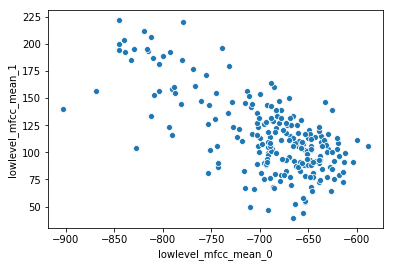

In [64]:
ax = sns.scatterplot(x=X_post.iloc[:, 0], y=X_post.iloc[:, 1], data=X_post)

In [65]:
X_post.head(10)

,lowlevel_mfcc_mean_0,lowlevel_mfcc_mean_1,lowlevel_mfcc_mean_2,lowlevel_mfcc_mean_3,lowlevel_mfcc_mean_4,lowlevel_mfcc_mean_5,lowlevel_mfcc_mean_6,lowlevel_mfcc_mean_7,lowlevel_mfcc_mean_8,lowlevel_mfcc_mean_9,lowlevel_mfcc_mean_10,lowlevel_mfcc_mean_11,lowlevel_mfcc_mean_12
0,-667.883118,125.089531,-7.107424,11.511266,-5.148409,-3.897772,-7.113338,-9.346775,-10.095614,-5.573277,-11.271605,1.358371,-1.678014
1,-632.708801,109.515961,-6.743139,33.957977,6.720649,15.185560,-0.506176,9.835093,0.249996,-1.285302,-4.519786,-4.935949,-6.043912
2,-631.180603,77.058716,-24.825384,8.864532,30.978905,21.604908,7.822349,7.301024,-2.647747,0.250000,-15.727395,-7.010809,-9.118421
3,-588.672913,105.884094,4.430345,18.902775,10.956851,1.277229,-2.805600,4.014971,3.412809,1.268016,-1.093371,-1.061570,-4.554092
4,-647.584351,102.621666,-5.122541,32.075142,5.030038,-3.234941,-4.141649,1.258927,-4.110200,-10.787242,-5.912789,-2.080896,-8.131037
5,-604.108337,91.001709,-4.865090,13.637306,12.561028,17.375835,1.627080,7.203180,6.226099,3.652996,6.053452,0.933916,0.970638
6,-627.428345,86.962372,-22.361172,42.459892,23.146502,11.323879,1.205414,7.321868,1.677439,-0.509632,-0.506957,1.360139,-6.301170
7,-623.327087,75.199951,5.571994,38.267181,5.131464,11.543450,-3.885288,-0.844846,-0.948655,-4.466264,-2.282264,-1.821905,-3.977947
8,-599.421936,111.150894,-15.241917,8.193201,13.724219,0.002277,-5.332924,5.708433,2.525098,1.455290,-4.573675,-2.595445,-5.650586
9,-830.101196,195.195572,-26.017838,19.527437,5.400964,-26.731262,1.679128,9.635761,-4.259260,-7.447515,-10.677028,-5.608661,-3.382733


In [66]:
X_post.shape

(225, 13)

# ML

In [67]:
from sklearn.svm import SVC

In [68]:
from sklearn.model_selection import GridSearchCV

In [69]:
svm = SVC(gamma="auto", probability=True)

In [70]:
from sklearn.model_selection import KFold

In [71]:
from sklearn.model_selection import KFold

In [72]:
kf = KFold(n_splits=5,
           shuffle=False,
           random_state=None
        )

In [73]:
X_post_array = X_post.values

In [74]:
type(X_post_array)

numpy.ndarray

In [75]:
X_post_array.shape

(225, 13)

In [76]:
parameters_grid = {'kernel': ['poly', 'rbf'],
                   'C': [0.03125, 0.125, 0.5, 2, 8, 32, 128, 512, 2048],
                   'gamma': [8, 2, 0.5, 0.125, 0.03125, 0.0078125, 0.001953125, 0.00048828125],
                   'class_weight': [None, 'balanced']
                   }

In [77]:
gsvc = GridSearchCV(estimator=svm,
                    param_grid=parameters_grid,
                    cv=kf,
                    n_jobs=-1, 
                    verbose=10)

In [78]:
gsvc.fit(X_post_array, y)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.03125, 0.125, 0.5, 2, 8, 32, 128, 512, 2048],
                         'class_weight': [None, 'balanced'],
                         'gamma': [8, 2, 0.5, 0.125, 0.03125, 0.0078125,
                                   0.001953125, 0.00048828125],
                         'kernel': ['poly', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [79]:
print(gsvc.best_score_)
print(gsvc.best_estimator_)
print(gsvc.best_params_)

0.8444444444444444
SVC(C=8, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.00048828125, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
{'C': 8, 'class_weight': None, 'gamma': 0.00048828125, 'kernel': 'rbf'}


In [92]:
accuracy_model = []

In [93]:
# Iterate over each train-test split
for train_index, test_index in kf.split(X_post_array):
#     print("TRAIN INDEX: ", train_index)
#     print("TEST INDEX: ", test_index)
    # Split train-test
    X_train, X_test = X_post_array[train_index], X_post_array[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Train the model
    model = svm.fit(X_train, y_train)
    # Append to accuracy_model the accuracy of the model
    accuracy_model.append(accuracy_score(y_test, model.predict(X_test), normalize=True) * 100)

# Print the accuracy
print("Accuracies in every fold iteration: {}".format(accuracy_model))
print("Mean of all the accuracies: {}".format(sum(accuracy_model) / len(accuracy_model)))

Accuracies in every fold iteration: [46.666666666666664, 64.44444444444444, 86.66666666666667, 84.44444444444444, 37.77777777777778]
Mean of all the accuracies: 64.0


/home/iotlab_user/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/iotlab_user/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/iotlab_user/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/iotlab_user/anaconda3/lib/python3.

# Evaluation

In [94]:
from sklearn.metrics import confusion_matrix, classification_report

In [95]:
predictions = gsvc.predict(X_post_array)

In [97]:
prob_predictions = gsvc.predict_proba(X_post_array)
prob_predictions = prob_predictions * 100  # multiply * 100 for better results

AttributeError: predict_proba is not available when  probability=False

In [98]:
print("Classification Report:")
print("\n{}".format(classification_report(y, predictions)))

Classification Report:

               precision    recall  f1-score   support

    danceable       0.99      1.00      0.99       144
not_danceable       1.00      0.98      0.99        81

     accuracy                           0.99       225
    macro avg       0.99      0.99      0.99       225
 weighted avg       0.99      0.99      0.99       225



In [99]:
print("Confusion matrix:")
print("\n{}".format(confusion_matrix(y, predictions)))

Confusion matrix:

[[144   0]
 [  2  79]]


In [100]:
y.value_counts(normalize=True)

danceable        0.64
not_danceable    0.36
Name: danceability, dtype: float64

In [101]:
from sklearn.model_selection import cross_val_score

In [102]:
scores = cross_val_score(svm, X_post_array, y, cv=5)

/home/iotlab_user/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/iotlab_user/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/iotlab_user/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/iotlab_user/anaconda3/lib/python3.

In [103]:
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.6400 (+/- 0.0115)
